<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/database.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Mongo Atlas &amp; SingleStore Kai</h1>
    </div>
</div>

<img src=https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/notebooks/atlas-and-kai/images/mongo-db-singlestoredb.png width="100%">

# No code change required! 100% MongoDB notebook!

Given the small dataset, the objective of that notebook is not to compare performance.

## What you will learn in this notebook:

1. Install libraries and import modules
2. Connect to a MongoDB Atlas and SingleStoreDB Kai endpoints
3. Copy Atlas collections into SingleStoreDB - Synthetic collections are about retail sales transactions with customer information

## Compare performance on same code from simple to more complex queries

4. Document counts
5. Product quantity sold
6. Average customer satisfaction
7. Average satisfaction per product
8. Number of transactions by Location and membership
9. Top 10 product sales

## 1. Install libraries and import modules

**Make sure that you have a created MongoDB enabled workspace.**

This must be done when creating a workspace.

<img src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/notebooks/atlas-and-kai/images/mongo-enabled-workspace.png" style="width: 500">

In [15]:
!pip install pymongo pandas matplotlib plotly ipywidgets --quiet

In [16]:
import os
import time

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.subplots as sp
import pymongo
from pymongo import MongoClient
from plotly.offline import plot, iplot, init_notebook_mode

## 2. Connect to Atlas and SingleStoreDB Kai endpoints
We are using a shared tier on the backend for Atlas

In [17]:
# No need to edit anything
myclientmongodb = pymongo.MongoClient("mongodb+srv://<username>:<password>@<host>/?retryWrites=true&w=majority")
mydbmongodb = myclientmongodb["new_transactions"]
mongoitems = mydbmongodb["items"]
mongocusts = mydbmongodb["custs"]
mongotxs = mydbmongodb["txs"]

**Select the workspace that you want to use.**

<img src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/notebooks/atlas-and-kai/images/select-workspace-and-database.png" style="width: 500px; border: 1px solid darkorchid">

In [21]:
s2clientmongodb = pymongo.MongoClient(connection_url_mongo)
s2dbmongodb = s2clientmongodb["new_transactions"]
s2mongoitems = s2dbmongodb["items"]
s2mongocusts = s2dbmongodb["custs"]
s2mongotxs = s2dbmongodb["txs"]

## 3. Copy Atlas collections into SingleStoreDB Kai

In [22]:
# Nothing to do here as handled by CDC

Count documents in SingleStoreDB.

In [23]:
mg_count = s2mongoitems.count_documents({})
mg_count

147294

# Compare Queries and Performance

**In-app analytics is everywhere.**

<img src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/notebooks/atlas-and-kai/images/in-app-analytics.png" style="width: 600px; border: 1px solid darkorchid">

## 4. Document counts

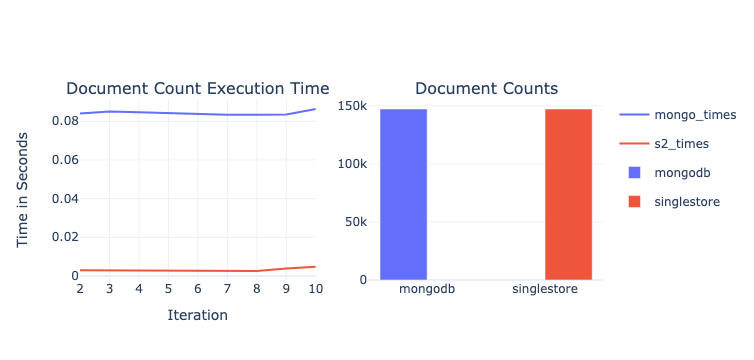

In [24]:
num_iterations = 10
mongo_times = []

for i in range(num_iterations):
    mg_start_time = time.time()
    mg_count = mongoitems.count_documents({})
    mg_stop_time = time.time()
    mongo_times.append(mg_stop_time - mg_start_time)

s2_times = []
for i in range(num_iterations):
    s2_start_time = time.time()
    s2_count = s2mongoitems.count_documents({})
    s2_stop_time = time.time()
    s2_times.append(s2_stop_time - s2_start_time)
    
df = pd.DataFrame.from_dict({
    'iteration': list(range(1, num_iterations + 1)),
    'mongo_times': mongo_times,
    's2_times': s2_times,
})

df_2 = pd.DataFrame.from_dict({
    'counts': [mg_count, s2_count],
    'connection_type': ["mongodb", "singlestore"],
})

figures = [
    px.line(df.iloc[1:], x='iteration', y=['mongo_times', 's2_times']),
    px.bar(df_2, x="connection_type", y="counts", color="connection_type")
]

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=["Document Count Execution Time","Document Counts"])
for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=1, col=i + 1)
        
fig.update_yaxes(title_text="Time in Seconds", row=1, col=1)
fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_xaxes(tickmode='array', tickvals=[1, 2, 3, 4, 5,6,7,8,9,10], row=1, col=1)

fig

## 5. Product Quantity Sold

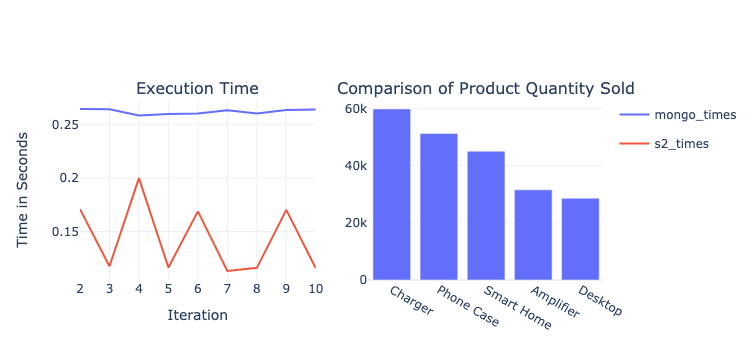

In [28]:
num_iterations = 10
mongo_times = []

pipeline = [
    {"$group": {"_id": "$item.name", "totalQuantity": {"$sum": "$item.quantity"}}},
    {"$sort": {"totalQuantity": -1}},
    {"$limit": 5},
]

for i in range(num_iterations):
    mg_start_time = time.time()
    mg_result = mongoitems.aggregate(pipeline)
    mg_stop_time = time.time()
    mongo_times.append(mg_stop_time - mg_start_time)

s2_times = []
for i in range(num_iterations):
    s2_start_time = time.time()
    s2_result = s2mongoitems.aggregate(pipeline)
    s2_stop_time = time.time()
    s2_times.append(s2_stop_time - s2_start_time)
    
x_axis = list(range(1, num_iterations + 1))
data = {
    'iteration': x_axis,
    'mongo_times': mongo_times,
    's2_times': s2_times,
}    
df = pd.DataFrame.from_dict(data)

item_names = [] 
item_quantity = []
for i in mg_result:
    item_names.append(i["_id"])
    item_quantity.append(i["totalQuantity"])

figures = [
    px.line(df.iloc[1:], x='iteration', y=['mongo_times', 's2_times']),
    px.bar(x=item_names, y=item_quantity)
]

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=["Execution Time","Comparison of Product Quantity Sold"])
for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=1, col=i+1)
        
fig.update_yaxes(title_text="Time in Seconds", row=1, col=1)
fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_xaxes(tickmode='array', tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], row=1, col=1)

fig

## 6. Average Customer Satisfaction

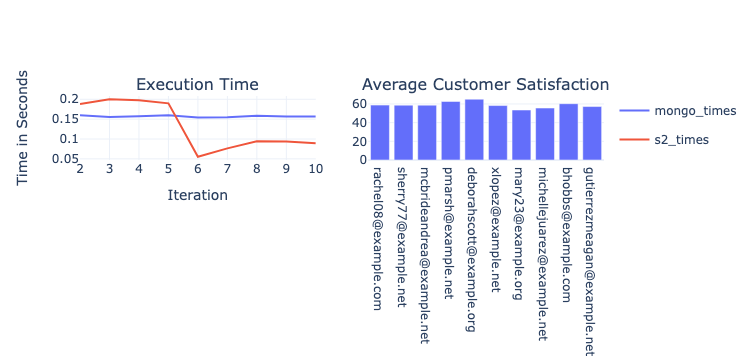

In [29]:
num_iterations = 10
mongo_times = []

pipeline = [
    {'$group': 
         {
          '_id': '$customer.email', 
          'average_satisfaction': {'$avg': '$customer.satisfaction'},
         },
    },
    {'$limit': 10},
]

for i in range(num_iterations):
    mg_start_time = time.time()
    mg_result = mongotxs.aggregate(pipeline)
    mg_stop_time = time.time()
    mongo_times.append(mg_stop_time - mg_start_time)

s2_times = []
for i in range(num_iterations):
    s2_start_time = time.time()
    s2_result = s2mongotxs.aggregate(pipeline)
    s2_stop_time = time.time()
    s2_times.append(s2_stop_time - s2_start_time)
    
x_axis = list(range(1, num_iterations + 1))
data = {
    'iteration': x_axis,
    'mongo_times': mongo_times,
    's2_times': s2_times,
}    
df = pd.DataFrame.from_dict(data)

item_names = [] 
item_quantity = []
for i in mg_result:
    item_names.append(i["_id"])
    item_quantity.append(i["average_satisfaction"])

figures = [
    px.line(df.iloc[1:], x='iteration', y=['mongo_times', 's2_times']),
    px.bar(x=item_names, y=item_quantity)
]

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=["Execution Time","Average Customer Satisfaction"])
for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=1, col=i+1)
        
fig.update_yaxes(title_text="Time in Seconds", row=1, col=1)
fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_xaxes(tickmode='array', tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], row=1, col=1)

fig

## 7. Average Satisfaction per Product

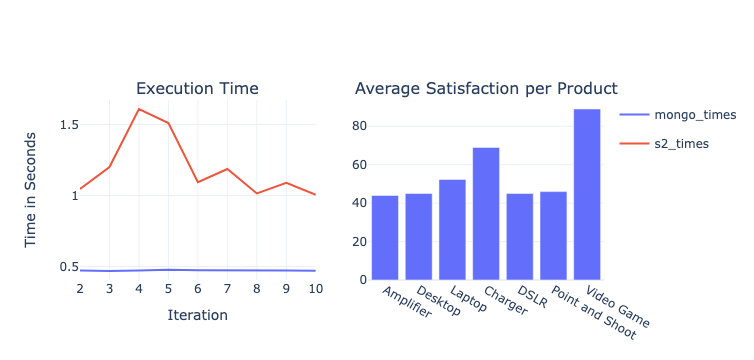

In [30]:
num_iterations = 10
mongo_times = []

pipeline = [
    {"$lookup":
         {
          "from": "txs",
          "localField": "tx_id",
          "foreignField": "transaction_id",
          "as": "transaction_links",
         }
    },
    {"$limit": 10 },
    {"$unwind": "$transaction_links"},
    {"$group": 
        {
         "_id": {"item": "$item.name"},
         "Average Satisfaction": {"$avg": "$transaction_links.customer.satisfaction"}
        }
    }
]

for i in range(num_iterations):
    mg_start_time = time.time()
    mg_result = mongoitems.aggregate(pipeline)
    mg_stop_time = time.time()
    mongo_times.append(mg_stop_time - mg_start_time)

s2_times = []
for i in range(num_iterations):
    s2_start_time = time.time()
    s2_result = s2mongoitems.aggregate(pipeline)
    s2_stop_time = time.time()
    s2_times.append(s2_stop_time - s2_start_time)
    
x_axis = list(range(1, num_iterations + 1))
data = {
    'iteration': x_axis,
    'mongo_times': mongo_times,
    's2_times': s2_times,
}    
df = pd.DataFrame.from_dict(data)

item_names = [] 
item_quantity = []
for i in mg_result:
    item_names.append(i["_id"]['item'])
    item_quantity.append(i["Average Satisfaction"])
    
figures = [
    px.line(df.iloc[1:], x='iteration', y=['mongo_times', 's2_times']),
    px.bar(x=item_names, y=item_quantity)
]

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=["Execution Time","Average Satisfaction per Product"])
for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=1, col=i+1)
        
fig.update_yaxes(title_text="Time in Seconds", row=1, col=1)
fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_xaxes(tickmode='array', tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], row=1, col=1)

fig

## 8. Number of transactions by location and membership

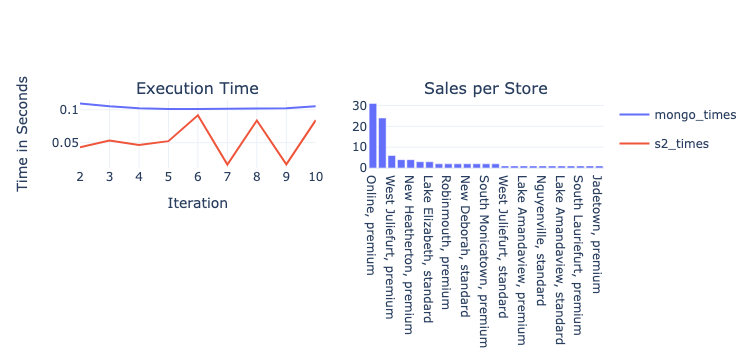

In [31]:
num_iterations = 10
mongo_times = []

pipeline = [
    {"$lookup":
         {
          "from": "custs",
          "localField": "customer.email",
          "foreignField": "email",
          "as": "transaction_links",
         }
    },
    {"$limit": 100},
    {"$group": 
        {
         "_id": {
                  "location": "$store_location",
                  "membership": "$transaction_links.membership"
                 },
         "count": {"$sum": 1}
        }
    },
    {"$sort": {"count":-1}}
]
for i in range (num_iterations):
    mg_start_time = time.time()
    mg_result = mongotxs.aggregate(pipeline)
    mg_stop_time = time.time()
    mongo_times.append(mg_stop_time - mg_start_time)

s2_times = []
for i in range (num_iterations):
    s2_start_time = time.time()
    s2_result = s2mongotxs.aggregate(pipeline)
    s2_stop_time = time.time()
    s2_times.append(s2_stop_time - s2_start_time)
    
x_axis = list(range(1, num_iterations + 1))
data = {
    'iteration': x_axis,
    'mongo_times': mongo_times,
    's2_times': s2_times,
}
df = pd.DataFrame.from_dict(data)

item_names = [] 
item_quantity = []
for i in mg_result:
    toadd = i["_id"]['location'] + ', ' + i["_id"]['membership'][0]
    item_names.append(toadd)
    item_quantity.append(i['count'])
    
figures = [
    px.line(df.iloc[1:], x='iteration', y=['mongo_times', 's2_times']),
    px.bar(x=item_names, y=item_quantity)
]

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=["Execution Time","Sales per Store"])
for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=1, col=i+1)

fig.update_yaxes(title_text="Time in Seconds", row=1, col=1)
fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_xaxes(tickmode='array', tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], row=1, col=1)

fig

## 9. Top 10 Product Sales

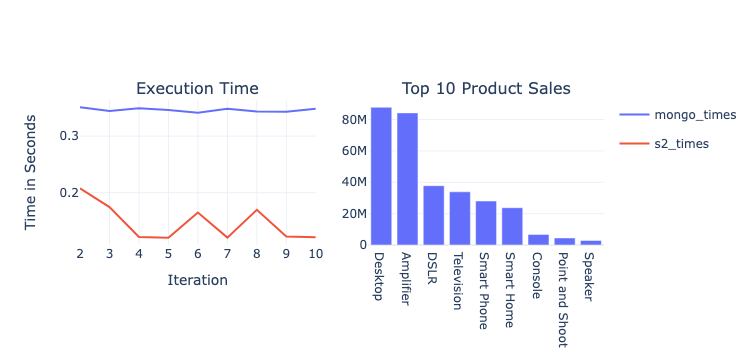

In [32]:
num_iterations = 10
mongo_times = []
pipeline = [
    {"$project": 
        {
         "item": 1,
         "revenue": {"$multiply": ["$item.price", "$item.quantity"]}
        }
    },
    {"$group": 
        {
         "_id": "$item.name",
         "total_revenue": {"$sum": "$revenue"}
        }
    },
    {"$sort": {"total_revenue": -1}},
    {"$limit": 10},
]

for i in range (num_iterations):
    mg_start_time = time.time()
    mg_result = mongoitems.aggregate(pipeline)
    mg_stop_time = time.time()
    mongo_times.append(mg_stop_time - mg_start_time)

s2_times = []
for i in range (num_iterations):
    s2_start_time = time.time()
    s2_result = s2mongoitems.aggregate(pipeline)
    s2_stop_time = time.time()
    s2_times.append(s2_stop_time - s2_start_time)
    
x_axis = [i + 1 for i in range(num_iterations)]
data = {
    'iteration': x_axis,
    'mongo_times': mongo_times,
    's2_times': s2_times,
}
df = pd.DataFrame.from_dict(data)

item_names = [] 
item_quantity = []
for i, result in enumerate(mg_result):
    if i >= 1:
        toadd = result["_id"]
        item_names.append(toadd)
        item_quantity.append(result['total_revenue'])

figures = [
    px.line(df.iloc[1:], x='iteration', y=['mongo_times', 's2_times']), # Exclude the first iteration from the line chart
    px.bar(x=item_names, y=item_quantity)
]

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=["Execution Time","Top 10 Product Sales"])
for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=1, col=i+1)

fig.update_yaxes(title_text="Time in Seconds", row=1, col=1)
fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_xaxes(tickmode='array', tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], row=1, col=1)

fig

<div id="singlestore-footer" style="background-color: rgba(194, 193, 199, 0.25); height:2px; margin-bottom:10px"></div>
<div><img src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/singlestore-logo-grey.png" style="padding: 0px; margin: 0px; height: 24px"/></div>